<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## RNN one-to-many

#### Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes RNN. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/)

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2022-07-01 12:54:37--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2022-07-01 12:54:37--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0s      

2022-07-01 12:54:37 (108 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2022-07-01 12:54:37--
Total wall clock time: 0.1s
Downloaded: 1 files, 23K in 0s (108 MB/s)


In [4]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    valid_loss = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = iter(valid_loader).next()
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Valid Loss {epoch_valid_loss:.3f}")

    history = {
        "loss": train_loss,
        "val_loss": valid_loss,
    }
    return history

In [5]:
# Generar datos sintéticos
X = list()
y = list()

# X es una lista de números de 1 al 43 que avanzan de 3 en 3
X = [x for x in range(1, 44, 3)]

# "y" (target) se obtiene como por cada dato de entrada se
# se obtienen dos datos de salida como x+1 y x+2
y = [ [x+1, x+2] for x in X]

print("datos X:", X)
print("datos y:", y)

datos X: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43]
datos y: [[2, 3], [5, 6], [8, 9], [11, 12], [14, 15], [17, 18], [20, 21], [23, 24], [26, 27], [29, 30], [32, 33], [35, 36], [38, 39], [41, 42], [44, 45]]


In [6]:
# Cada dato X lo transformarmos en una matriz de 1 fila 1 columna (1x1)
X = np.array(X).reshape(len(X), 1, 1)
print("datos X:", X)

datos X: [[[ 1]]

 [[ 4]]

 [[ 7]]

 [[10]]

 [[13]]

 [[16]]

 [[19]]

 [[22]]

 [[25]]

 [[28]]

 [[31]]

 [[34]]

 [[37]]

 [[40]]

 [[43]]]


In [7]:
# (batch size, seq_len, input_size)
X.shape

(15, 1, 1)

In [8]:
y = np.asanyarray(y)
y.shape

(15, 2)

In [9]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss unfction esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_dim = data_set.x.shape[1:]
seq_length = input_dim[0]
input_size = input_dim[1]
print("Input dim", input_dim)
print("seq_length:", seq_length)
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim torch.Size([1, 1])
seq_length: 1
input_size: 1
Output dim 2


In [10]:
data_set.x.shape

torch.Size([15, 1, 1])

In [11]:
data_set.y.shape

torch.Size([15, 2])

In [14]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

# Cuando trabajmos con una serie temporal no mezclamos (shuffle) los datos
train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 12
Tamaño del conjunto de validacion: 3


### 2 - Entrenar el modelo

In [12]:
from torch_helpers import CustomLSTM

class Model1(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()

        #self.rnn1 = nn.RNN(input_size=input_size, hidden_size=64, batch_first=True) # RNN layer
        # Utilizamos la CustomRNN ya que para series temporales suele funcionar mejor
        # la activacion "relu" en las RNN en vez de la "tanh", pero por defecto la
        # layer de Pytorch RNN no permite modificar la funcion de activacion
        #self.rnn1 = CustomRNN(input_size=input_size, hidden_size=64) # RNN layer
        self.rnn1 = CustomLSTM(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # RNN layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.rnn1(x)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model1 = Model1(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
model1_criterion = nn.MSELoss()  # mean squared error

summary(model1, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 2]                    --
├─CustomLSTM: 1-1                        [1, 1, 64]                16,896
│    └─Sigmoid: 2-1                      [1, 64]                   --
│    └─Sigmoid: 2-2                      [1, 64]                   --
│    └─ReLU: 2-3                         [1, 64]                   --
│    └─Sigmoid: 2-4                      [1, 64]                   --
│    └─ReLU: 2-5                         [1, 64]                   --
├─Linear: 1-2                            [1, 2]                    130
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [15]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 462.355 - Valid Loss 1645.288
Epoch: 2/500 - Train loss 449.647 - Valid Loss 1595.563
Epoch: 3/500 - Train loss 436.923 - Valid Loss 1542.512
Epoch: 4/500 - Train loss 423.058 - Valid Loss 1482.594
Epoch: 5/500 - Train loss 407.156 - Valid Loss 1413.558
Epoch: 6/500 - Train loss 388.677 - Valid Loss 1333.730
Epoch: 7/500 - Train loss 367.355 - Valid Loss 1241.423
Epoch: 8/500 - Train loss 342.932 - Valid Loss 1135.327
Epoch: 9/500 - Train loss 315.275 - Valid Loss 1015.040
Epoch: 10/500 - Train loss 284.417 - Valid Loss 881.632
Epoch: 11/500 - Train loss 250.619 - Valid Loss 738.088
Epoch: 12/500 - Train loss 214.433 - Valid Loss 589.436
Epoch: 13/500 - Train loss 176.758 - Valid Loss 442.449
Epoch: 14/500 - Train loss 138.841 - Valid Loss 305.013
Epoch: 15/500 - Train loss 102.255 - Valid Loss 185.223
Epoch: 16/500 - Train loss 68.777 - Valid Loss 90.527
Epoch: 17/500 - Train loss 40.382 - Valid Loss 27.567
Epoch: 18/500 - Train loss 19.018 - Valid Loss 1.170

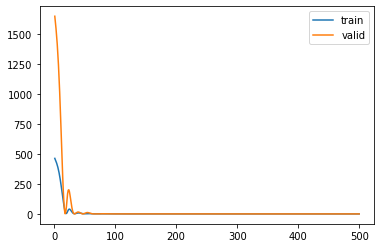

In [16]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='valid')
plt.show()

In [17]:
# Ensayo
x_test = 10
y_test = [x_test + 1, x_test + 2]
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model1(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model1_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: [11, 12]
y_hat: tensor([[11.0004, 12.0687]], grad_fn=<AddmmBackward0>)
loss: 0.5364619493484497


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### 3 - Multi-layer LSTM

In [18]:
from torch_helpers import CustomLSTM

# En esta oportunidad se utilizarán dos layer LSTM
class Model2(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()

        self.lstm1 = CustomLSTM(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.lstm2 = CustomLSTM(input_size=64, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.lstm1(x)
        lstm_output, _ = self.lstm2(lstm_output)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model2 = Model2(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
model2_criterion = nn.MSELoss()  # mean squared error

summary(model2, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 2]                    --
├─CustomLSTM: 1-1                        [1, 1, 64]                16,896
├─CustomLSTM: 1                          --                        --
│    └─Sigmoid: 2-1                      [1, 64]                   --
│    └─Sigmoid: 2-2                      [1, 64]                   --
├─CustomLSTM: 1                          --                        --
│    └─ReLU: 2-3                         [1, 64]                   --
├─CustomLSTM: 1                          --                        --
│    └─Sigmoid: 2-4                      [1, 64]                   --
├─CustomLSTM: 1                          --                        --
│    └─ReLU: 2-5                         [1, 64]                   --
├─CustomLSTM: 1-2                        [1, 1, 64]                33,024
│    └─Sigmoid: 2-6                      [1, 64]                   --
│    └─

In [19]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 470.314 - Valid Loss 1724.781
Epoch: 2/500 - Train loss 467.929 - Valid Loss 1713.987
Epoch: 3/500 - Train loss 465.140 - Valid Loss 1694.561
Epoch: 4/500 - Train loss 460.645 - Valid Loss 1656.527
Epoch: 5/500 - Train loss 452.558 - Valid Loss 1585.815
Epoch: 6/500 - Train loss 438.152 - Valid Loss 1467.096
Epoch: 7/500 - Train loss 413.713 - Valid Loss 1289.118
Epoch: 8/500 - Train loss 374.876 - Valid Loss 1050.281
Epoch: 9/500 - Train loss 318.913 - Valid Loss 767.279
Epoch: 10/500 - Train loss 246.870 - Valid Loss 463.499
Epoch: 11/500 - Train loss 163.997 - Valid Loss 181.160
Epoch: 12/500 - Train loss 81.845 - Valid Loss 10.403
Epoch: 13/500 - Train loss 21.010 - Valid Loss 106.299
Epoch: 14/500 - Train loss 16.392 - Valid Loss 452.939
Epoch: 15/500 - Train loss 74.102 - Valid Loss 588.090
Epoch: 16/500 - Train loss 102.103 - Valid Loss 462.242
Epoch: 17/500 - Train loss 80.693 - Valid Loss 255.158
Epoch: 18/500 - Train loss 43.432 - Valid Loss 93.115
E

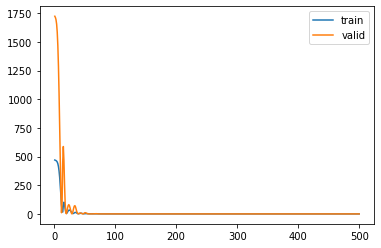

In [20]:
epoch_count = range(1, len(history2['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_loss'], label='valid')
plt.show()

In [21]:
# Ensayo
x_test = 10
y_test = [x_test + 1, x_test + 2]
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model2(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model2_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: [11, 12]
y_hat: tensor([[11.0020, 12.0384]], grad_fn=<AddmmBackward0>)
loss: 0.5189282298088074


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### 4 - Conclusión
La unica diferencia que se debe tener en cuenta cuando hay más de una salida es que la cantidad de neuronas de la última capa debe coincidir con el tamaño de la secuencia de salida.
En este ejemplo, donde el problema es más complejo, hubo una diferencia apreciable entre utilizar una sola capa o varias LSTM.